In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss, accuracy_score, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm.sklearn import LGBMRegressor, LGBMClassifier
from tqdm.notebook import tqdm
warnings.filterwarnings(action='ignore') 


import os
path = os.getcwd().replace('\\', '/') + '/'

In [293]:
plant1 = pd.read_csv(path + 'plant1_train.csv', parse_dates=[0], index_col=[0])
plant2 = pd.read_csv(path + 'plant2_train.csv', parse_dates=[0], index_col=[0])
test = pd.read_csv(path + 'test.csv', parse_dates=[0], index_col=[0])
forecast = pd.read_csv(path + 'weather2.csv', parse_dates=[0], index_col=[0])
# aws = pd.read_csv(path + 'aws_weather.csv', parse_dates=[0], index_col=[0])
# asos = pd.read_csv(path + 'asos_weather.csv', parse_dates=[0], index_col=[0])


In [294]:
def dewpoint(temp, humid):
    return ((243.12 *((17.62 * temp /(243.12 + temp)) + np.log(humid / 100.0))) 
            / (17.62-((17.62 * temp / (243.12 + temp)) + np.log(humid/ 100.0))))

In [295]:
# Goff-Gratch 포화수증기압
def svp(temp):
    T = temp + 273.15
    log10p = ( 
        - 7.90298 * ( (373.16/T) - 1 )
        + 5.02808 * np.log10( 373.16/T )
        - 1.3816e-7 * (np.power(10, 11.344*( (1-T)/373.16) ) - 1)
        + 8.1328e-3 * (np.power(10, -3.49149*( 373.16/(T-1) ) ) - 1)
        + np.log10(1013.246) 
    )
    p = np.power(10, log10p)

    return p

In [296]:
plant1.columns = [col.replace('plant1_train.', '') for col in plant1.columns]
plant2.columns = [col.replace('plant2_train.', '') for col in plant2.columns]

In [297]:
data  = pd.concat([plant1,forecast], axis=1)
data2 = pd.concat([plant2,forecast], axis=1)

In [298]:
# 1공장
# 보간
inp = data.loc[:, 'temp_25':'rain_46']
data.update(inp.interpolate())
tempTrain = data.dropna()
# train test set.
train = tempTrain['2017-02':'2019-03'].resample('1h').asfreq().dropna().reset_index()
test = tempTrain['2017-02':'2019-03'].resample('1h').asfreq().dropna().reset_index()

In [307]:
# 2공장
# 보간
inp = data2.loc[:, 'temp_25':'rain_46']
data2.update(inp.interpolate())
tempTrain2 = data2.dropna()
# train test set.
train2 = tempTrain2['2017-02':'2019-03'].resample('1h').asfreq().dropna().reset_index()
test2 = tempTrain2['2017-02':'2019-03'].resample('1h').asfreq().dropna().reset_index()

In [236]:
def get_train_test(train, test):
    tem_col = ['tem_in_loc1', 'tem_in_loc2', 'tem_in_loc3', 'tem_out_loc1', 'temp_25', 'temp_46']
    hum_col = ['hum_in_loc1', 'hum_in_loc2', 'hum_in_loc3', 'hum_out_loc1', 'humid_25','humid_46']

    # 기상청 예보 데이터 이동평균 설정
    train_X = train.drop(['cond_loc1', 'cond_loc2', 'cond_loc3'], axis=1)
    ma6 =  train_X.rolling(6).mean().filter(regex='(25|46)').add_prefix('MA6_')
    ma24 = train_X.rolling(24).mean().filter(regex='(25|46)').add_prefix('MA24_')
    train_X = pd.concat([train_X, ma6, ma24], axis=1).dropna()

    test_X = test.drop(['cond_loc1', 'cond_loc2', 'cond_loc3'], axis=1)
    ma6 =  test_X.rolling(6).mean().filter(regex='(25|46)').add_prefix('MA6_')
    ma24 = test_X.rolling(24).mean().filter(regex='(25|46)').add_prefix('MA24_')
    test_X = pd.concat([test_X, ma6, ma24], axis=1).dropna()

    
    train_X = train_X.set_index('index')
    test_X = test_X.set_index('index')

    plant_env_col = ['tem_in_loc1', 'hum_in_loc1', 'tem_coil_loc1', 'tem_in_loc2', 'hum_in_loc2', 'tem_coil_loc2', 'tem_in_loc3', 'hum_in_loc3', 'tem_coil_loc3', 'tem_out_loc1', 'hum_out_loc1']

    # y 설정    
    
    train_y24 = train_X.shift(-24).dropna()[plant_env_col].add_prefix('y25_')
    train_y48 = train_X.shift(-48).dropna()[plant_env_col].add_prefix('y46_')
    
    test_y24 = test_X.shift(-24).dropna()[plant_env_col].add_prefix('y25_')
    test_y48 = test_X.shift(-48).dropna()[plant_env_col].add_prefix('y46_')

    train = pd.concat([train_X, train_y24, train_y48], axis=1).dropna()
    test = pd.concat([test_X, test_y24, test_y48], axis=1).dropna()

    train_X = train.iloc[:, :-22]
    train_Y = train.iloc[:, -22:]

    test_X = test.iloc[:, :-22]
    test_Y = test.iloc[:, -22:]

    # scale = StandardScaler().fit(train_X)
    # train_X.loc[:, :] = scale.transform(train_X)
    # test_X.loc[:, :] = scale.transform(test_X)

    return train_X, train_Y, test_X, test_Y

In [342]:
kfold = KFold(n_splits=5, shuffle=True, random_state=8)


<generator object _BaseKFold.split at 0x000001AA18367EC8>

In [345]:
for train_idx, val_idx in kfold.split(train_X) :
    print(val_idx)

[   11    14    17 ... 18658 18659 18661]
[    0     2     9 ... 18652 18653 18655]
[    1     3    21 ... 18633 18634 18649]
[    6     7    15 ... 18647 18654 18656]
[    4     5     8 ... 18644 18657 18660]


In [237]:
def tree_train_model(x_data, y_data, k=5):
    models = []
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=777)
    val = 0
    for train_idx, val_idx in k_fold.split(x_data):
        x_train, y_train = x_data.iloc[train_idx], y_data.iloc[train_idx]
        x_val, y_val = x_data.iloc[val_idx], y_data.iloc[val_idx]
    
        model = LGBMRegressor(**params) 
        model.fit(x_train, y_train, eval_set=(x_val, y_val), verbose=1000)
        pred = model.predict(x_val)
        val += mean_absolute_error(y_val, pred)/k

        models.append(model)
    
    return models, val

In [357]:
ElasticNet?

In [238]:
def linear_train_model(x_data, y_data, k=5):
    models = []
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=777)
    val = 0
    for train_idx, val_idx in k_fold.split(x_data):
        x_train, y_train = x_data.iloc[train_idx], y_data.iloc[train_idx]
        x_val, y_val = x_data.iloc[val_idx], y_data.iloc[val_idx]
    
        model = ElasticNet(alpha=0.005, l1_ratio=0.6, tol=0.0001, max_iter=100000, random_state=777)
        model.fit(x_train, y_train)
        pred = model.predict(x_val)
        val += mean_absolute_error(y_val, pred)/k

        models.append(model)
    
    return models, val

In [346]:
def train_model(x_data, y_data, k=5):
    models = []
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=777)
    val = 0
    for train_idx, val_idx in k_fold.split(x_data):
        x_train, y_train = x_data.iloc[train_idx], y_data.iloc[train_idx]
        x_val, y_val = x_data.iloc[val_idx], y_data.iloc[val_idx]
    
        model = KNeighborsRegressor(n_neighbors=50, weights='distance', )
        model.fit(x_train, y_train)
        pred = model.predict(x_val)
        val += mean_absolute_error(y_val, pred)/k

        models.append(model)
    
    return models, val

In [347]:
# lightGBM 파라미터 설정
params = {
    'num_iterations' : 1000,
    'learning_rate' : 0.1,
    'num_leaves': 31,
    'bagging_fraction' : 0.7,
    'bagging_freq' : 50,
    'early_stopping_round' : 30,
    
    'max_depth' : 10
}


In [348]:
# 1공장 데이터
linear_train_X, linear_train_Y, linear_test_X, linear_test_Y = get_train_test(train, test)

# 1공장 내부 환경 예측 모델

linear_models1 = {}
linear_vals1 = {}
linear_scaler1 = {}


for time_label in ['25', '46']:
    _y = linear_train_Y.filter(regex=f'y{time_label}_')
    
    for label in _y.columns:
        target = f'{label}'
        print('train column : ', target)
        time_col = linear_train_X.filter(regex= f'_{time_label}$').columns.to_list()        
        in_col = linear_train_X.filter(regex=f'(in|coil)_loc{label[-1]}').columns.to_list()
        out_col = linear_train_X.filter(regex=f'out_loc1').columns.to_list()

        if 'out_loc1' in label:
            tcol = time_col + out_col
        else:
            tcol = time_col + in_col 
        print(tcol)
        x = linear_train_X.loc[:, tcol]
        scaler = StandardScaler().fit(x)
        x.loc[:,:] = scaler.transform(x)
        linear_scaler1[target] = scaler
        linear_models1[target], linear_vals1[target] = linear_train_model(x, _y[label])
        


train column :  y25_tem_in_loc1
['temp_25', 'humid_25', 'rain_25', 'MA6_temp_25', 'MA6_humid_25', 'MA6_rain_25', 'MA24_temp_25', 'MA24_humid_25', 'MA24_rain_25', 'tem_in_loc1', 'hum_in_loc1', 'tem_coil_loc1']
train column :  y25_hum_in_loc1
['temp_25', 'humid_25', 'rain_25', 'MA6_temp_25', 'MA6_humid_25', 'MA6_rain_25', 'MA24_temp_25', 'MA24_humid_25', 'MA24_rain_25', 'tem_in_loc1', 'hum_in_loc1', 'tem_coil_loc1']
train column :  y25_tem_coil_loc1
['temp_25', 'humid_25', 'rain_25', 'MA6_temp_25', 'MA6_humid_25', 'MA6_rain_25', 'MA24_temp_25', 'MA24_humid_25', 'MA24_rain_25', 'tem_in_loc1', 'hum_in_loc1', 'tem_coil_loc1']
train column :  y25_tem_in_loc2
['temp_25', 'humid_25', 'rain_25', 'MA6_temp_25', 'MA6_humid_25', 'MA6_rain_25', 'MA24_temp_25', 'MA24_humid_25', 'MA24_rain_25', 'tem_in_loc2', 'hum_in_loc2', 'tem_coil_loc2']
train column :  y25_hum_in_loc2
['temp_25', 'humid_25', 'rain_25', 'MA6_temp_25', 'MA6_humid_25', 'MA6_rain_25', 'MA24_temp_25', 'MA24_humid_25', 'MA24_rain_25', 

In [349]:
plant1_pred = pd.DataFrame()
for col in linear_models1:
    preds = []
    time_col = linear_train_X.filter(regex= f'{col[1:3]}$').columns.to_list()        
    in_col = linear_train_X.filter(regex=f'(in|coil)_loc{col[-1]}').columns.to_list()
    out_col = linear_train_X.filter(regex=f'out_loc1').columns.to_list()
    
    if 'out_loc1' in col:
        tcol = time_col + out_col
    else:
        tcol = time_col + in_col
    x = linear_train_X[tcol]
    scaler = linear_scaler1[col]
    x.loc[:,:] = scaler.transform(x)

    for model in linear_models1[col]:        
        preds.append(model.predict(x))    

    pred = np.mean(preds, axis=0)
    plant1_pred[col] = pred  

plant1_pred.index = linear_train_X.index

In [350]:
linear_train_X[tcol]

,temp_46,humid_46,rain_46,MA6_temp_46,MA6_humid_46,MA6_rain_46,MA24_temp_46,MA24_humid_46,MA24_rain_46,tem_out_loc1,hum_out_loc1
index,,,,,,,,,,,
2017-02-01 23:00:00,-1.000000,80.000000,20.000000,1.666667,70.000000,20.000000,0.375000,74.166667,10.416667,-2.85,53.30
2017-02-02 00:00:00,-1.666667,81.666667,20.000000,0.611111,74.166667,20.000000,0.361111,74.305556,11.250000,-3.10,50.85
2017-02-02 01:00:00,-2.333333,83.333333,20.000000,-0.333333,77.500000,20.000000,0.333333,74.375000,12.083333,-3.37,51.13
2017-02-02 02:00:00,-3.000000,85.000000,20.000000,-1.166667,80.000000,20.000000,0.291667,74.375000,12.916667,-3.49,50.27
2017-02-02 03:00:00,-3.333333,86.666667,20.000000,-1.888889,82.222222,20.000000,0.236111,74.444444,13.750000,-3.71,48.14
...,...,...,...,...,...,...,...,...,...,...,...
2019-03-29 19:00:00,6.666667,36.666667,3.333333,7.333333,42.500000,8.333333,5.083333,59.791667,16.250000,8.47,52.50
2019-03-29 20:00:00,6.000000,35.000000,0.000000,7.166667,40.000000,6.666667,5.041667,58.958333,15.000000,8.53,58.42
2019-03-29 21:00:00,5.000000,41.666667,0.000000,6.777778,39.166667,5.000000,5.000000,58.333333,13.888889,8.29,52.29


In [351]:
# 2공장 데이터
linear_train_X, linear_train_Y, linear_test_X, linear_test_Y = get_train_test(train2, test2)

# 2공장 내부 환경 예측 모델

linear_models2 = {}
linear_vals2 = {}
linear_scaler2 = {}

for time_label in ['25', '46']:
    _y = linear_train_Y.filter(regex=f'y{time_label}_')
    
    for label in _y.columns:
        target = f'{label}'
        print('train column : ', target)
        time_col = linear_train_X.filter(regex= f'_{time_label}$').columns.to_list()        
        in_col = linear_train_X.filter(regex=f'(in|coil)_loc{label[-1]}').columns.to_list()
        out_col = linear_train_X.filter(regex=f'out_loc1').columns.to_list()

        if 'out_loc1' in label:
            tcol = time_col + out_col
        else:
            tcol = time_col + in_col

        x = linear_train_X.loc[:, tcol]
        scaler = StandardScaler().fit(x)
        x.loc[:,:] = scaler.transform(x)
        linear_scaler2[target] = scaler

        linear_models2[target], linear_vals2[target] = linear_train_model(x, _y[label])
        #tree_models2[target], tree_vals2[target] = tree_train_model(tree_train_X.loc[:, tcol + ['month', 'hour']], _y[label])


train column :  y25_tem_in_loc1
train column :  y25_hum_in_loc1
train column :  y25_tem_coil_loc1
train column :  y25_tem_in_loc2
train column :  y25_hum_in_loc2
train column :  y25_tem_coil_loc2
train column :  y25_tem_in_loc3
train column :  y25_hum_in_loc3
train column :  y25_tem_coil_loc3
train column :  y25_tem_out_loc1
train column :  y25_hum_out_loc1
train column :  y46_tem_in_loc1
train column :  y46_hum_in_loc1
train column :  y46_tem_coil_loc1
train column :  y46_tem_in_loc2
train column :  y46_hum_in_loc2
train column :  y46_tem_coil_loc2
train column :  y46_tem_in_loc3
train column :  y46_hum_in_loc3
train column :  y46_tem_coil_loc3
train column :  y46_tem_out_loc1
train column :  y46_hum_out_loc1


In [352]:
plant2_pred = pd.DataFrame()
for col in linear_models2:
    preds = []
    time_col = linear_train_X.filter(regex= f'{col[1:3]}$').columns.to_list()        
    in_col = linear_train_X.filter(regex=f'(in|coil)_loc{col[-1]}').columns.to_list()
    out_col = linear_train_X.filter(regex=f'out_loc1').columns.to_list()
    
    if 'out_loc1' in col:
        tcol = time_col + out_col
    else:
        tcol = time_col + in_col

    
    x = linear_train_X[tcol]
    scaler = linear_scaler2[col]
    x.loc[:,:] = scaler.transform(x)
    
    for model in linear_models2[col]:        
        preds.append(model.predict(x))    

    pred = np.mean(preds, axis=0)
    plant2_pred[col] = pred  

plant2_pred.index = linear_train_X.index

In [353]:
train = train.set_index('index')
cond24 = train[['cond_loc1', 'cond_loc2', 'cond_loc3']].shift(-24).add_prefix('y25_')
cond48 = train[['cond_loc1', 'cond_loc2', 'cond_loc3']].shift(-48).add_prefix('y46_')

plant1_second = pd.concat([plant1_pred, cond24, cond48], axis=1).dropna() 

In [354]:
tem_col = plant1_second.filter(regex='tem_in_').columns
hum_col = plant1_second.filter(regex='hum_in_').columns
coil_col = plant1_second.filter(regex='coil_').columns

for i in range(len(tem_col)):
    dew_col = f'{tem_col[i][:3]}_dewpoint_{tem_col[i][-7:]}'
    plant1_second[dew_col] = dewpoint(plant1_second[tem_col[i]], plant1_second[hum_col[i]])
    
#     svp_col = f'{tem_col[i][:3]}_svp_{tem_col[i][-7:]}'
#     plant1_second[svp_col] = svp(plant1_second[tem_col[i]])
    
#     TDRi_col =  f'{tem_col[i][:3]}_dewpoint_{tem_col[i][-7:]}'
#     plant1_second[TDRi_col] = dewpoint(plant1_second[tem_col[i]], plant1_second[hum_col[i]])
    
    plant1_second[f'{tem_col[i][:3]}_dewdiff_{tem_col[i][-7:]}'] = plant1_second[coil_col[i]] - plant1_second[dew_col]

plant1_second['month'] = plant1_second.index.month
plant1_second['day'] = plant1_second.index.day
plant1_second['hour'] = plant1_second.index.hour

In [355]:
train2 = train2.set_index('index')
cond24 = train2[['cond_loc1', 'cond_loc2', 'cond_loc3']].shift(-24).add_prefix('y25_')
cond48 = train2[['cond_loc1', 'cond_loc2', 'cond_loc3']].shift(-48).add_prefix('y46_')

plant2_second = pd.concat([plant2_pred, cond24, cond48], axis=1).dropna() 

In [356]:
tem_col = plant2_second.filter(regex='tem_in_').columns
hum_col = plant2_second.filter(regex='hum_in_').columns
coil_col = plant2_second.filter(regex='coil_').columns

for i in range(len(tem_col)):
    dew_col = f'{tem_col[i][:3]}_dewpoint_{tem_col[i][-7:]}'
    plant2_second[dew_col] = dewpoint(plant2_second[tem_col[i]], plant2_second[hum_col[i]])

#     svp_col = f'{tem_col[i][:3]}_svp_{tem_col[i][-7:]}'
#     plant2_second[svp_col] = svp(plant2_second[tem_col[i]])
    
    plant2_second[f'{tem_col[i][:3]}_dewdiff_{tem_col[i][-7:]}'] = plant2_second[coil_col[i]] - plant2_second[dew_col]

plant2_second['month'] = plant2_second.index.month
plant2_second['day'] = plant2_second.index.day
plant2_second['hour'] = plant2_second.index.hour

# 2차 예측

In [250]:
def train_second_model(x_data, y_data, k=5):
    models = []
    sk_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=777)
    #k_fold = KFold(n_splits=k, shuffle=True, random_state=777)
    loss = 0
    score = 0
    for train_idx, val_idx in sk_fold.split(x_data, y_data):
        x_train, y_train = x_data.iloc[train_idx], y_data[train_idx]
        x_val, y_val = x_data.iloc[val_idx], y_data[val_idx]
    
        model = LGBMClassifier(n_estimators=100, learning_rate=0.01, is_unbalance=True, objective='binary') #RandomForestClassifier(n_jobs=-1)
        model.fit(x_train, y_train)
        pred = model.predict_proba(x_val)
        loss += log_loss(y_val, pred)/k
        score += roc_auc_score(y_val, pred[:, 1])/k

        models.append(model)
    
    return (models, (loss, score))

In [251]:
plant1_second_X = plant1_second.drop(['y25_cond_loc1', 'y25_cond_loc2', 'y25_cond_loc3', 'y46_cond_loc1', 'y46_cond_loc2', 'y46_cond_loc3'], axis=1 )
plant1_second_Y = plant1_second.filter(regex='cond')

plant2_second_X = plant2_second.drop(['y25_cond_loc1', 'y25_cond_loc2', 'y25_cond_loc3', 'y46_cond_loc1', 'y46_cond_loc2', 'y46_cond_loc3'], axis=1 )
plant2_second_Y = plant2_second.filter(regex='cond')

In [252]:
# from imblearn.over_sampling import RandomOverSampler

In [253]:
# X_samp, y_samp = RandomOverSampler(random_state=0).fit_sample(second_X.values, second_Y.values)
# second_X = pd.DataFrame(X_samp, columns = second_X.columns)
# second_Y = pd.DataFrame(y_samp, columns = second_Y.columns)

In [254]:
from sklearn.model_selection import train_test_split

plant1_second_X, val_x, plant1_second_Y, val_y = train_test_split(plant1_second_X, plant1_second_Y, test_size=0.2, random_state = 777)
plant2_second_X, val_x, plant2_second_Y, val_y = train_test_split(plant2_second_X, plant2_second_Y, test_size=0.2, random_state = 777)

In [258]:
# 1공장 결로 예측 
second_models1 = {}
second_eval1 = {}
for time_label in ['y25', 'y46']:
    X_time = plant1_second_X.filter(regex=f'{time_label}')
    y_time = plant1_second_Y.filter(regex=f'{time_label}_cond')
    for loc_label in ['loc1', 'loc2', 'loc3']:
        print(f'train : {time_label}_{loc_label}')
        y = y_time.filter(regex=f'{loc_label}')
        in_col = X_time.filter(regex=f'(in|coil)_{loc_label}').columns.to_list()
        out_col = X_time.filter(regex=f'out_loc1').columns.to_list()
        date_col = ['month','day', 'hour']
        
        
        tcol = in_col + date_col    
        
        
        print(tcol)
        second_models1[f'{time_label}_{loc_label}'], second_eval1[f'{time_label}_{loc_label}'] = train_second_model(plant1_second_X[tcol], y.values.reshape(-1,))

train : y25_loc1
['y25_tem_in_loc1', 'y25_hum_in_loc1', 'y25_tem_coil_loc1', 'y25_dewpoint_in_loc1', 'y25_dewdiff_in_loc1', 'month', 'day', 'hour']
train : y25_loc2
['y25_tem_in_loc2', 'y25_hum_in_loc2', 'y25_tem_coil_loc2', 'y25_dewpoint_in_loc2', 'y25_dewdiff_in_loc2', 'month', 'day', 'hour']
train : y25_loc3
['y25_tem_in_loc3', 'y25_hum_in_loc3', 'y25_tem_coil_loc3', 'y25_dewpoint_in_loc3', 'y25_dewdiff_in_loc3', 'month', 'day', 'hour']
train : y46_loc1
['y46_tem_in_loc1', 'y46_hum_in_loc1', 'y46_tem_coil_loc1', 'y46_dewpoint_in_loc1', 'y46_dewdiff_in_loc1', 'month', 'day', 'hour']
train : y46_loc2
['y46_tem_in_loc2', 'y46_hum_in_loc2', 'y46_tem_coil_loc2', 'y46_dewpoint_in_loc2', 'y46_dewdiff_in_loc2', 'month', 'day', 'hour']
train : y46_loc3
['y46_tem_in_loc3', 'y46_hum_in_loc3', 'y46_tem_coil_loc3', 'y46_dewpoint_in_loc3', 'y46_dewdiff_in_loc3', 'month', 'day', 'hour']


In [259]:
# 2공장 결로 예측 
second_models2 = {}
second_eval2 = {}
for time_label in ['y25', 'y46']:
    X_time = plant2_second_X.filter(regex=f'{time_label}')
    y_time = plant2_second_Y.filter(regex=f'{time_label}_cond')
    for loc_label in ['loc1', 'loc2', 'loc3']:
        print(f'train : {time_label}_{loc_label}')
        y = y_time.filter(regex=f'{loc_label}')
        in_col = X_time.filter(regex=f'(in|coil)_{loc_label}').columns.to_list()
        out_col = X_time.filter(regex=f'out_loc1').columns.to_list()
        date_col = ['month','day', 'hour']
        
        
        tcol = in_col + date_col   
        
        
        print(tcol)
        second_models2[f'{time_label}_{loc_label}'], second_eval2[f'{time_label}_{loc_label}'] = train_second_model(plant2_second_X[tcol], y.values.reshape(-1,))

train : y25_loc1
['y25_tem_in_loc1', 'y25_hum_in_loc1', 'y25_tem_coil_loc1', 'y25_dewpoint_in_loc1', 'y25_dewdiff_in_loc1', 'month', 'day', 'hour']
train : y25_loc2
['y25_tem_in_loc2', 'y25_hum_in_loc2', 'y25_tem_coil_loc2', 'y25_dewpoint_in_loc2', 'y25_dewdiff_in_loc2', 'month', 'day', 'hour']
train : y25_loc3
['y25_tem_in_loc3', 'y25_hum_in_loc3', 'y25_tem_coil_loc3', 'y25_dewpoint_in_loc3', 'y25_dewdiff_in_loc3', 'month', 'day', 'hour']
train : y46_loc1
['y46_tem_in_loc1', 'y46_hum_in_loc1', 'y46_tem_coil_loc1', 'y46_dewpoint_in_loc1', 'y46_dewdiff_in_loc1', 'month', 'day', 'hour']
train : y46_loc2
['y46_tem_in_loc2', 'y46_hum_in_loc2', 'y46_tem_coil_loc2', 'y46_dewpoint_in_loc2', 'y46_dewdiff_in_loc2', 'month', 'day', 'hour']
train : y46_loc3
['y46_tem_in_loc3', 'y46_hum_in_loc3', 'y46_tem_coil_loc3', 'y46_dewpoint_in_loc3', 'y46_dewdiff_in_loc3', 'month', 'day', 'hour']


In [260]:
test_pred = {}
for time_label in ['y25', 'y46']:
    X_time = val_x.filter(regex=f'{time_label}')
    y_time = val_y.filter(regex=f'{time_label}_cond')
    for loc_label in ['loc1', 'loc2', 'loc3']:
        print(f'pred : {loc_label}_{time_label}')
        y = y_time.filter(regex=f'{loc_label}')
        #in_col = X_time.filter(regex=f'dewdiff_in_{loc_label}').columns.to_list()
        in_col = X_time.filter(regex=f'(in|coil)_{loc_label}').columns.to_list()
        out_col = X_time.filter(regex=f'out_loc1').columns.to_list()
        date_col = ['month','day', 'hour']
        
        
        tcol = in_col + date_col
        
        
        print(tcol)
        p = np.zeros(y.shape[0])
        for m in second_models2[f'{time_label}_{loc_label}']:
            p += (m.predict_proba(val_x[tcol])/5)[:, 1].reshape(-1,)
        test_pred[f'{loc_label}_{time_label}'] = (y.filter(regex=loc_label).values.reshape(-1,), p)

pred : loc1_y25
['y25_tem_in_loc1', 'y25_hum_in_loc1', 'y25_tem_coil_loc1', 'y25_dewpoint_in_loc1', 'y25_dewdiff_in_loc1', 'month', 'day', 'hour']
pred : loc2_y25
['y25_tem_in_loc2', 'y25_hum_in_loc2', 'y25_tem_coil_loc2', 'y25_dewpoint_in_loc2', 'y25_dewdiff_in_loc2', 'month', 'day', 'hour']
pred : loc3_y25
['y25_tem_in_loc3', 'y25_hum_in_loc3', 'y25_tem_coil_loc3', 'y25_dewpoint_in_loc3', 'y25_dewdiff_in_loc3', 'month', 'day', 'hour']
pred : loc1_y46
['y46_tem_in_loc1', 'y46_hum_in_loc1', 'y46_tem_coil_loc1', 'y46_dewpoint_in_loc1', 'y46_dewdiff_in_loc1', 'month', 'day', 'hour']
pred : loc2_y46
['y46_tem_in_loc2', 'y46_hum_in_loc2', 'y46_tem_coil_loc2', 'y46_dewpoint_in_loc2', 'y46_dewdiff_in_loc2', 'month', 'day', 'hour']
pred : loc3_y46
['y46_tem_in_loc3', 'y46_hum_in_loc3', 'y46_tem_coil_loc3', 'y46_dewpoint_in_loc3', 'y46_dewdiff_in_loc3', 'month', 'day', 'hour']


In [283]:
from sklearn.metrics import confusion_matrix
for m in test_pred:
    print(f'{m} - classification report')
    true, pred = test_pred[m]
    print(confusion_matrix(true, pred>0.3))

loc1_y25 - classification report
[[3687   21]
 [   5   24]]
loc2_y25 - classification report
[[3684   23]
 [   3   27]]
loc3_y25 - classification report
[[3726    9]
 [   0    2]]
loc1_y46 - classification report
[[3698   16]
 [   3   20]]
loc2_y46 - classification report
[[3692   16]
 [   3   26]]
loc3_y46 - classification report
[[3724   12]
 [   0    1]]


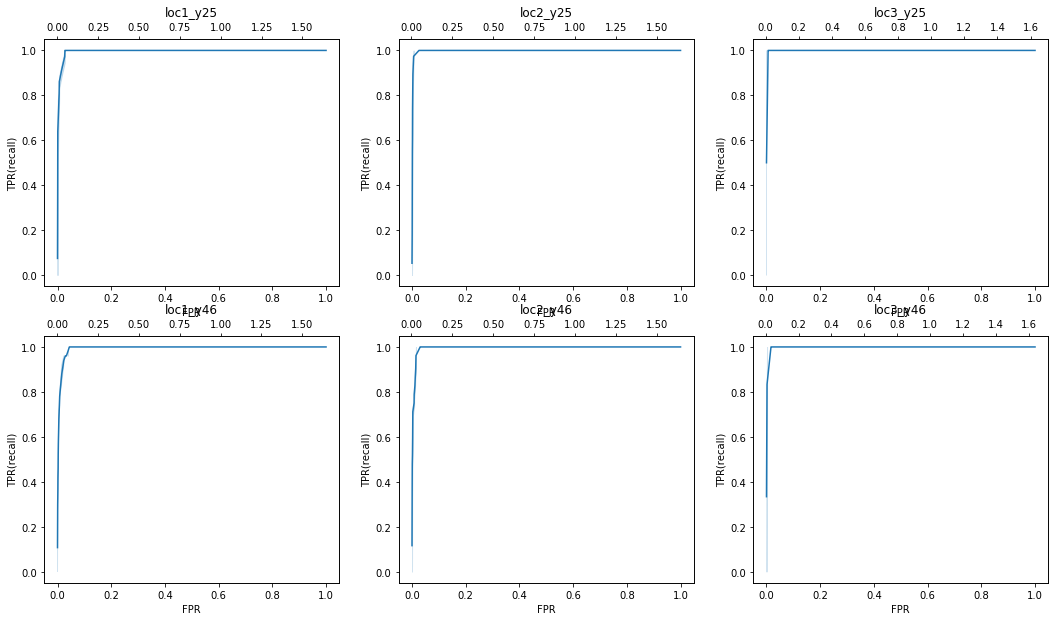

In [214]:
# from sklearn.metrics import classification_report, roc_curve

# # ROC curve
# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
# axes = axes.flat
# for i, m in enumerate(test_pred):    
#     true, pred = test_pred[m]
#     fpr, tpr, threadholds = roc_curve(true, pred)
#     ax = sns.lineplot(fpr, tpr, ax=axes[i])
#     ax.set(
#         title = m, 
#         xlabel = 'FPR', 
#         ylabel = 'TPR(recall)'
#     )
#     ax.twiny()
#     sns.lineplot(threadholds, tpr, visible=False)
    
# #     print(classification_report(true, pred))

# 테스트셋 적용

In [126]:
forecast_model = {
    '1' : linear_models1,
    '2' : linear_models2,
}
scalers = {
    '1' : linear_scaler1,
    '2' : linear_scaler2,
}
classifiers = {
    '1' : second_models1,
    '2' : second_models2,
}

In [127]:
test = pd.read_csv(path + 'test.csv', parse_dates=[0], index_col=[0])
test.columns = [col.replace('plant_test.', '') for col in test.columns]
test

,plant,loc,tem_in,hum_in,tem_coil,tem_out_loc1,hum_out_loc1,x24h_tma,x24h_cond_loc,x48h_tma,x48h_cond_loc
plant_test.mea_ddhr,,,,,,,,,,,
2019-04-01 00:00:00,2,3,8.17,40.42,10.10,4.20,54.82,2019-04-02 0:00,NaN,2019-04-03 0:00,NaN
2019-04-01 04:30:00,1,2,10.03,48.81,10.79,6.09,59.34,2019-04-02 4:30,NaN,2019-04-03 4:30,NaN
2019-04-01 10:30:00,2,3,9.45,40.93,9.07,12.26,32.14,2019-04-02 10:30,NaN,2019-04-03 10:30,NaN
2019-04-01 11:00:00,1,1,12.32,34.13,10.86,12.32,28.27,2019-04-02 11:00,NaN,2019-04-03 11:00,NaN
2019-04-01 13:30:00,2,1,11.28,22.65,8.76,12.01,19.84,2019-04-02 13:30,NaN,2019-04-03 13:30,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2020-03-29 03:00:00,1,2,10.73,33.36,13.30,6.28,46.37,2020-03-30 3:00,NaN,2020-03-31 3:00,NaN
2020-03-29 05:00:00,2,3,9.15,38.86,11.70,1.39,74.33,2020-03-30 5:00,NaN,2020-03-31 5:00,NaN
2020-03-29 07:00:00,2,1,7.10,44.87,9.03,4.26,58.06,2020-03-30 7:00,NaN,2020-03-31 7:00,NaN


In [128]:
# 날씨 예보 데이터 
forecast_ref = forecast.asfreq('30min')
forecast_ref = forecast_ref.interpolate()

ma6 = forecast_ref.rolling(6).mean().add_prefix('MA6_')
ma24= forecast_ref.rolling(24).mean().add_prefix('MA24_')
forecast_ref = pd.concat([forecast_ref, ma6, ma24], axis=1).dropna()

In [129]:
test

,plant,loc,tem_in,hum_in,tem_coil,tem_out_loc1,hum_out_loc1,x24h_tma,x24h_cond_loc,x48h_tma,x48h_cond_loc
plant_test.mea_ddhr,,,,,,,,,,,
2019-04-01 00:00:00,2,3,8.17,40.42,10.10,4.20,54.82,2019-04-02 0:00,NaN,2019-04-03 0:00,NaN
2019-04-01 04:30:00,1,2,10.03,48.81,10.79,6.09,59.34,2019-04-02 4:30,NaN,2019-04-03 4:30,NaN
2019-04-01 10:30:00,2,3,9.45,40.93,9.07,12.26,32.14,2019-04-02 10:30,NaN,2019-04-03 10:30,NaN
2019-04-01 11:00:00,1,1,12.32,34.13,10.86,12.32,28.27,2019-04-02 11:00,NaN,2019-04-03 11:00,NaN
2019-04-01 13:30:00,2,1,11.28,22.65,8.76,12.01,19.84,2019-04-02 13:30,NaN,2019-04-03 13:30,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2020-03-29 03:00:00,1,2,10.73,33.36,13.30,6.28,46.37,2020-03-30 3:00,NaN,2020-03-31 3:00,NaN
2020-03-29 05:00:00,2,3,9.15,38.86,11.70,1.39,74.33,2020-03-30 5:00,NaN,2020-03-31 5:00,NaN
2020-03-29 07:00:00,2,1,7.10,44.87,9.03,4.26,58.06,2020-03-30 7:00,NaN,2020-03-31 7:00,NaN


In [130]:
result = pd.DataFrame(columns=['plant', 'loc', '24h_cond_proba', '48h_cond_proba'])
for idx in tqdm(range(len(test))):
    data = test.iloc[idx:idx+1, :7]
    tidx = data.index[0].strftime('%Y-%m-%d %T')
    fc = forecast_ref[tidx:tidx]
    current = pd.concat([data.iloc[:, 2:], fc], axis=1)
    plant = str(data['plant'][0])
    loc = f"loc{data['loc'][0]}"
    
    time24_col = current.filter(regex='_25').columns
    time48_col = current.filter(regex='_46').columns
    
    second_df = pd.DataFrame(index=data.index)
    in_col = ['tem_in','hum_in','tem_coil']
    out_col = ['tem_out_loc1','hum_out_loc1']
    for time in ['25', '46']:
        for col in ['tem_in','hum_in','tem_coil','tem_out_loc1','hum_out_loc1']:        
            preds = []
            time_col = current.filter(regex=f'_{time}').columns.to_list()
            if 'out_' in col:                                
                tcol = time_col + out_col
                x = scalers[plant][f"y{time}_{col}"].transform(current[tcol])
                for model in forecast_model[plant][f"y{time}_{col}"]:
                    preds.append(model.predict(x))
                pred = np.mean(preds, axis=0)
            else:
                tcol = time_col + in_col
                x = scalers[plant][f"y{time}_{col}_{loc}"].transform(current[tcol])                
                for model in forecast_model[plant][f"y{time}_{col}_{loc}"]:
                    preds.append(model.predict(x))
                pred = np.mean(preds, axis=0)
            second_df[f"{time}_{col}"] = pred

    tem_col = second_df.filter(regex='tem_in').columns
    hum_col = second_df.filter(regex='hum_in').columns
    coil_col = second_df.filter(regex='coil').columns

    for i in range(len(tem_col)):
        dew_col = f'{tem_col[i][:3]}dewpoint{tem_col[i][-7:]}'
        second_df[dew_col] = dewpoint(second_df[tem_col[i]], second_df[hum_col[i]])

        second_df[f'{tem_col[i][:3]}dewdiff{tem_col[i][-7:]}'] = second_df[coil_col[i]] - second_df[dew_col]

    second_df['month'] = second_df.index.month
    second_df['day'] = second_df.index.day
    second_df['hour'] = second_df.index.hour
    
    p = {
        '25' : 0,
        '46' : 0,
    }
    for time_label in ['25', '46']:
        X_time = second_df.filter(regex=f'{time_label}')
        in_col = X_time.filter(regex=f'(in|coil)').columns.to_list()
        out_col = X_time.filter(regex=f'out_loc1').columns.to_list()
        date_col = ['month','day', 'hour']
        tcol = in_col + out_col + date_col        
        
        for m in classifiers[plant][f'y{time_label}_{loc}']:
            p[time_label] += ( m.predict_proba(second_df[tcol]) / 5 )[:, 1].reshape(-1,)[0]
    
    result.loc[idx, :] = [plant, loc[-1], p['25'], p['46']]

In [131]:
result

,plant,loc,24h_cond_proba,48h_cond_proba
0,2,3,0.000315048,0.000313263
1,1,2,0.0039179,0.0039179
2,2,3,0.000315048,0.000319477
3,1,1,0.00225579,0.00225579
4,2,1,0.00250065,0.00250065
...,...,...,...,...
3534,1,2,0.0039179,0.0039179
3535,2,3,0.000315048,0.000315048
3536,2,1,0.00250065,0.00250065
3537,1,1,0.00225579,0.00225579


In [132]:
sample = pd.read_csv(path + 'sample.csv')
sample

FileNotFoundError: [Errno 2] File b'C:/Users/student/Desktop/weater_contest/sample.csv' does not exist: b'C:/Users/student/Desktop/weater_contest/sample.csv'

In [ ]:
sample['X24H_COND_LOC'] = np.where(result['24h_cond_proba']>0.3, 1, 0)
sample['X24H_COND_LOC_PROB'] = result['24h_cond_proba']
sample['X48H_COND_LOC'] = np.where(result['48h_cond_proba']>0.3, 1, 0)
sample['X48H_COND_LOC_PROB'] = result['48h_cond_proba']

In [ ]:
sample.to_csv(path+'203752.csv', index=False)